processing: 0.tif


/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


processing: 1.tif
processing: 10.tif
processing: 11.tif
processing: 12.tif
processing: 13.tif
processing: 2.tif
processing: 20.tif
processing: 22.tif
processing: 23.tif
processing: 3.tif
processing: 30.tif
processing: 31.tif
processing: 40.tif
processing: 41.tif
processing: 5.tif
processing: 51.tif
processing: 52.tif
processing: 53.tif
processing: 54.tif
processing: 61.tif
processing: 63.tif
processing: 70.tif
processing: 71.tif
processing: 72.tif
processing: 73.tif
processing: 80.tif
processing: 81.tif
processing: 82.tif
processing: 83.tif
processing: 90.tif
processing: 91.tif
processing: 94.tif
processing: 96.tif
[('0.tif', 1.4104260740755905), ('1.tif', 1.5499983925827132), ('10.tif', 1.474142524938199), ('11.tif', 1.5790258335426492), ('12.tif', 1.3926749948987527), ('13.tif', 1.6475966139881717), ('2.tif', 1.4439181473585194), ('20.tif', 1.6185467243679847), ('22.tif', 1.6401489628008967), ('23.tif', 1.3794755557881195), ('3.tif', 1.382381752953368), ('30.tif', 1.5166032249296908)

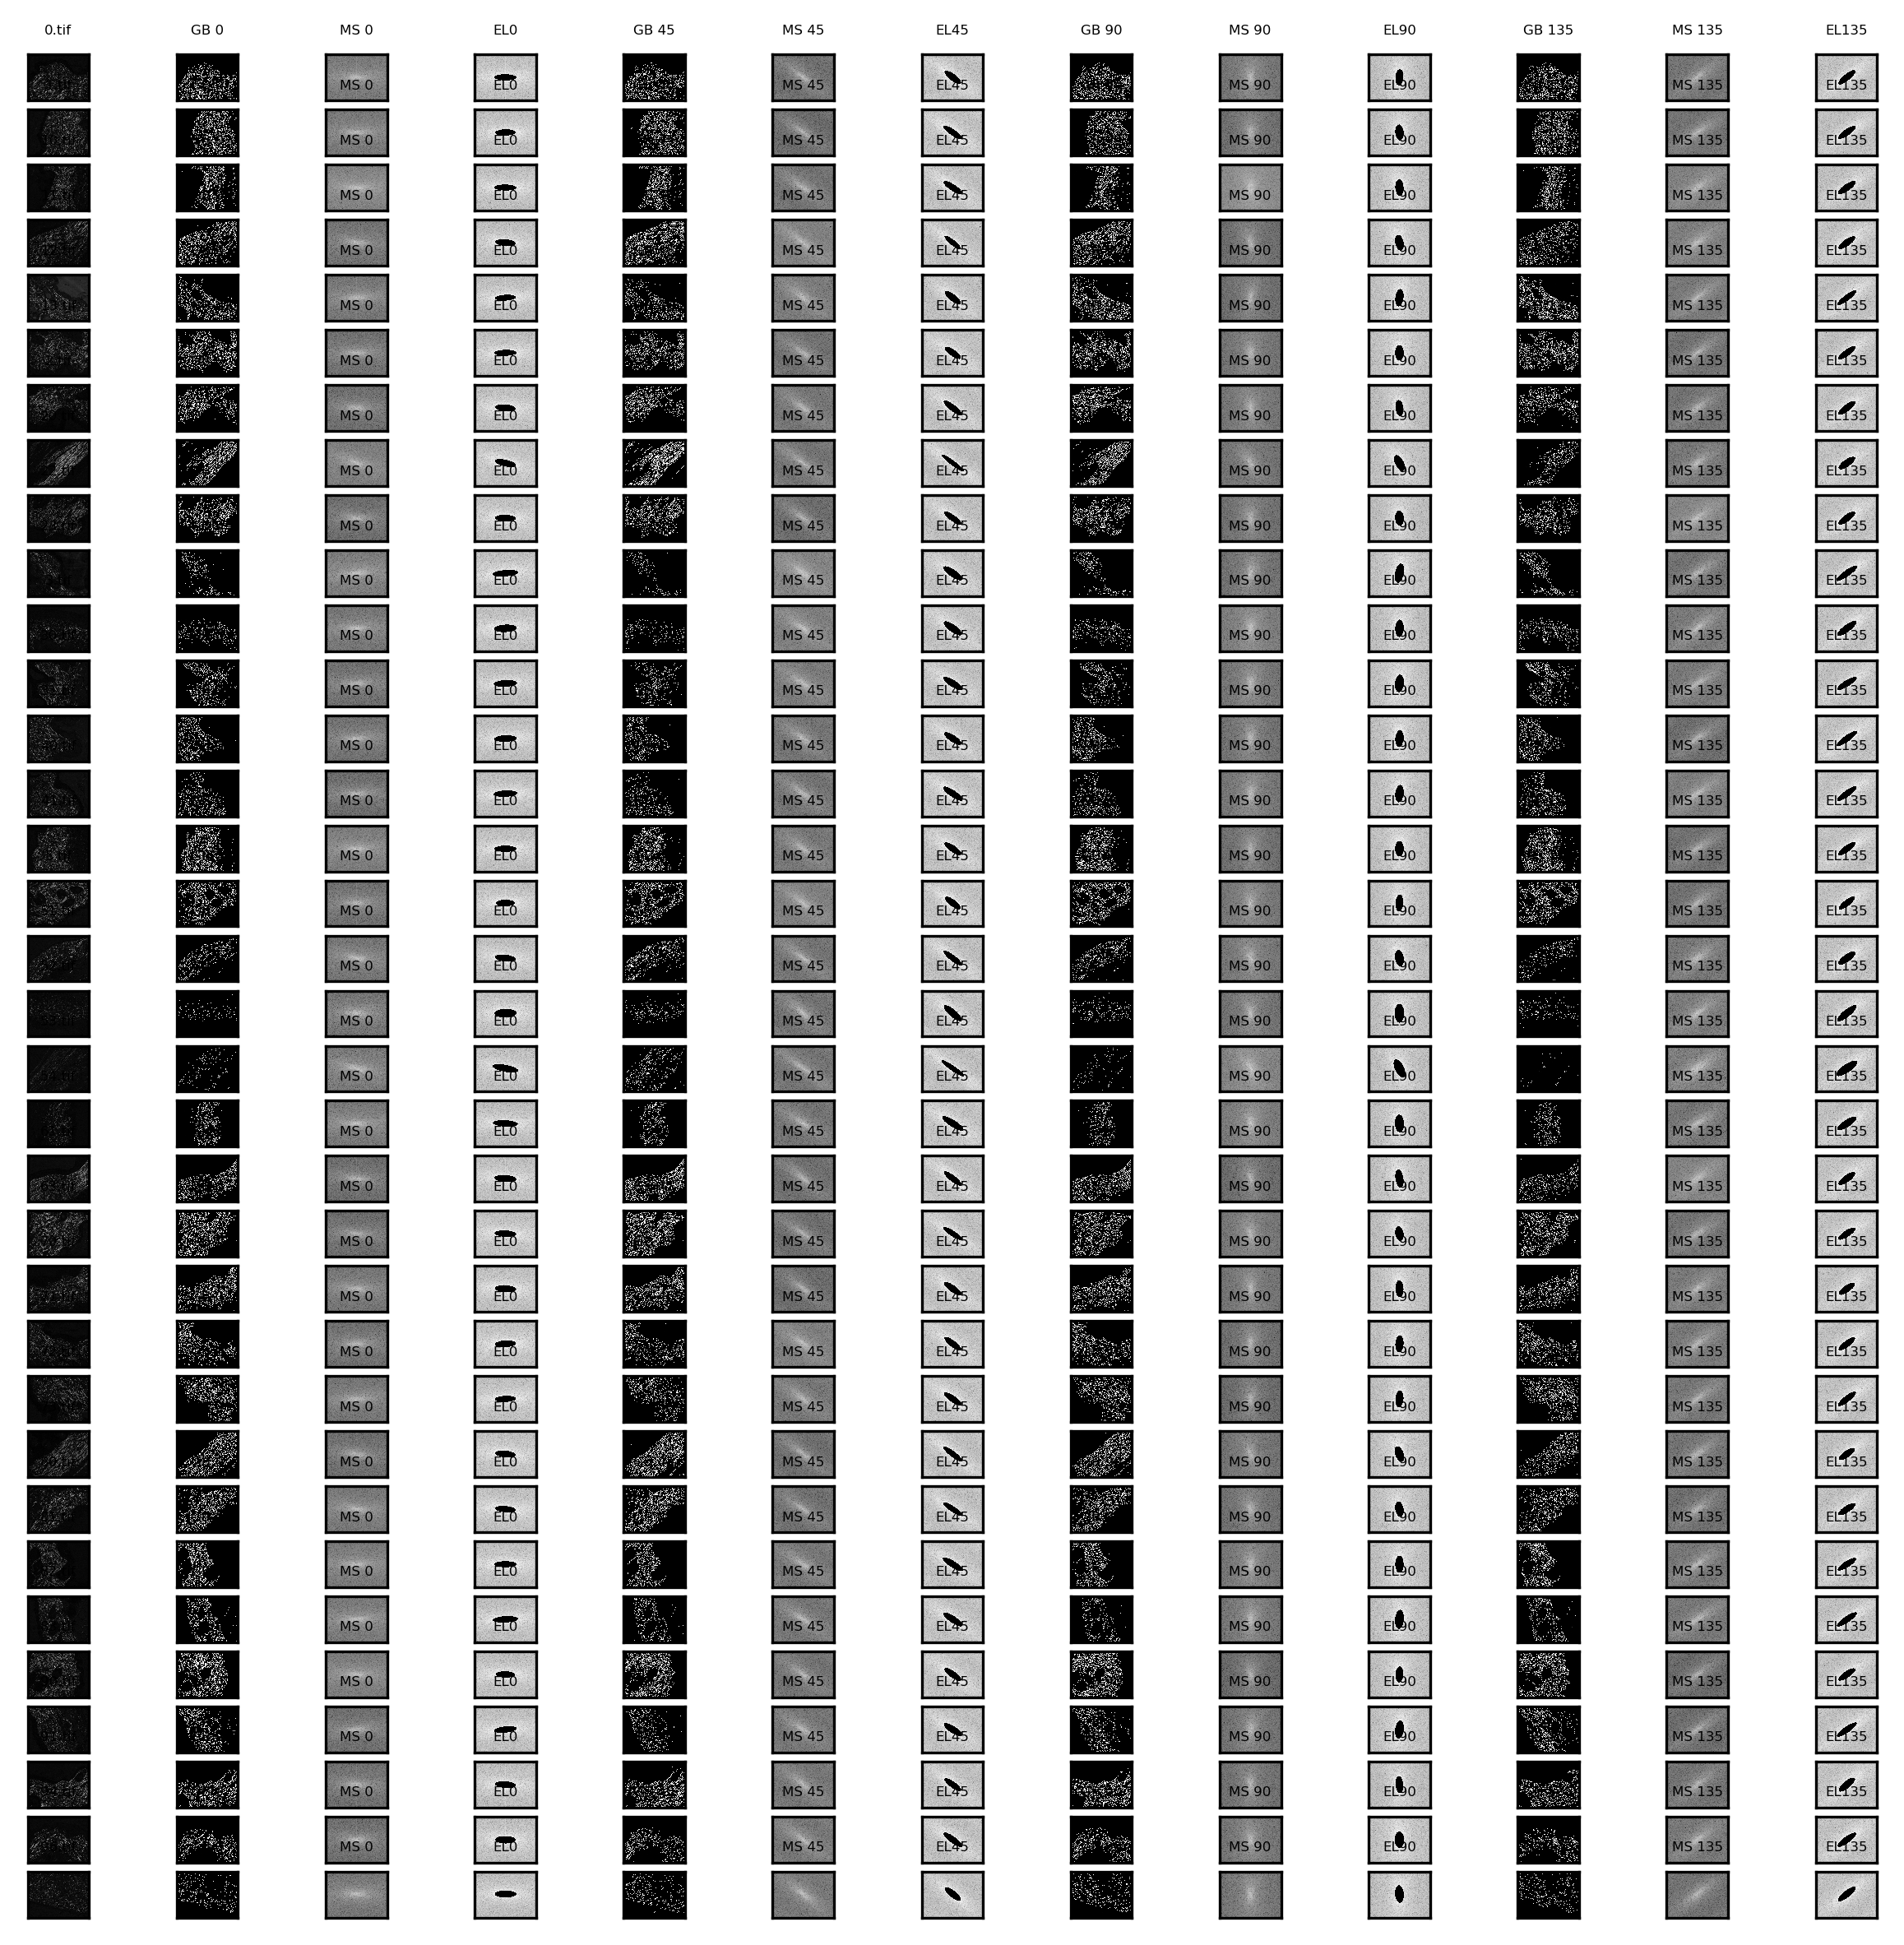

In [8]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage.morphology import dilation,convex_hull_image
import cv2
from scipy import ndimage
import os
from skimage import color,io,filters,morphology,img_as_ubyte
import csv
import re

#input
dir = r"/Volumes/FRANKLIN/basal psr/"

def fin(dir):
    re_im = re.compile(".*\.tif$")
    TopLevelFiles = []
    for [dirpath,dirnames,filenames] in os.walk(dir):
        for file in filenames:
            if re.match(re_im,file):
                fpath = dirpath+file
                TopLevelFiles.append((str(fpath),str(file)))
        break
    return(TopLevelFiles)

#gabor filter
#degree vars are in radians- 1 radian is 57.3 degrees
#condition -45 
#variables
orientation = [0,0.785398,1.5708,2.35619] #0,45,90,135 degs -> 0, 0.785398, 1.5708, 2.35619
frequency = 0.1 #0.1 worked for the buckingham set taken @ 90x but frequency will need to be higher for low mag
deg_offset = 0 #not sure what this is for
colormap = "gray"
kernel_shape = morphology.square(3) #for median filter

def gab_fft(image,orient): #only one color layer
    mf = filters.median(image,kernel_shape) #median filter
    gb = filters.gabor(mf,frequency,theta=orient,sigma_x=3.0,sigma_y=5.0,n_stds=5) #gabor filter
    gb_real = gb[0]
    gb_imag = gb[1]
    ft = np.fft.fft2(np.abs(gb_imag)) #fast fourier transform
    fs = np.fft.fftshift(ft)#get frequency transform
    ms = np.log(np.abs(fs))#/np.log(np.abs(fs)).max() #make visible
    deg=orient*57.3
    
    #get ellipse
    thresh = filters.threshold_li(ms)
    binary = ms > thresh*1.20
    edges = canny(binary.astype('float64'), sigma=3)
    fillerizer = convex_hull_image(edges)

    real_edges = canny(fillerizer,sigma=1)
    image1 = img_as_ubyte(real_edges)

    bimage = cv2.GaussianBlur(image1, (3, 3), 0)
    edge_image = cv2.Canny(bimage, 107, 208,
    apertureSize=3, L2gradient=False)

    img2 = cv2.dilate(edge_image, np.ones((3, 3)), iterations=3)
    dis_image = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)


    labels, count = ndimage.label(img2)

    for lab, idx in enumerate(ndimage.find_objects(labels.astype(int)), 1):
        sy = idx[0].start
        sx = idx[1].start
        y, x = np.where(labels[idx] == lab)
        ellp = cv2.fitEllipse(np.column_stack((x+sx, y+sy)))
        q = cv2.ellipse(np.copy(ms), ellp, (0, 0, 255),thickness=-1)
    long = ellp[1][1]
    short = ellp[1][0]
    ratio = 1-(short/long)+0.001
    #end of get ellipse
    
    
    
    return (image,mf,gb_imag,ms,deg,ft,fs,ratio,q)

    


results = []
ims = fin(dir)
fig, ax = plt.subplots(len(ims),13,figsize=(10,10),dpi=300)

#fig.subplots_adjust(hspace = .5, wspace=.001)

i=0
for image in ims:
    print("processing: "+str(image[1]))
    nratios=[]
    q=0
    rgb=io.imread(image[0])
    gray=color.rgb2gray(rgb)
    ax[i,q].imshow(gray,cmap="gray")
    ax[i,q].set_title(str(image[1]),size=4) #
    ax[i,q].set_xticks([])
    ax[i,q].set_yticks([])
    q = q+1
    

    for ori in orientation:
        original,med_filt,gab_filt,mag_spec,deg,ft,fs,Nratio,ell_overlay = gab_fft(gray,ori)
        ax[i,q].imshow(gab_filt,cmap="gray")
        ax[i,q].set_title("GB "+str(int(deg)),size=4) #
        ax[i,q].set_xticks([])
        ax[i,q].set_yticks([])
        
        
        #ax[i,q].set_title(image[1]+"gabor"+str(ori))
        q = q+1
        
        ax[i,q].imshow(mag_spec,cmap="gray")
        ax[i,q].set_title("MS "+str(int(deg)),size=4)  #
        ax[i,q].set_xticks([])
        ax[i,q].set_yticks([])
        
        q = q+1
        
        ax[i,q].imshow(ell_overlay,cmap="gray")
        ax[i,q].set_title("EL"+str(int(deg)),size=4)  #
        ax[i,q].set_xticks([])
        ax[i,q].set_yticks([])
        
        q = q+1
        nratios.append(Nratio)
    ori_index = max(nratios)/min(nratios)
    results.append((str(image[1]),ori_index))
    i=i+1

print(results)

fig.savefig('basal psr.pdf',dpi=300,bbox_inches='tight',format='pdf')
with open('basal psr.csv','w') as csvfile:
    fout = csv.writer(csvfile)
    for res in results:
        fout.writerow(res)




